Author: Rene Pickhardt

This notebook investigates several things: 

* [Done] how often and far does the max_flow / min_cut diviate from the payment pairs existing incoming and outgoing liquidity 
* [X] Given a twosplit what is the best split ratio? 
* [X] How do various discussed splitting strategies behave?

In [32]:
import json
import networkx as nx
import random
import matplotlib.pyplot as plt

## Setup and data import

In [7]:
def import_channel_graph():
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.Graph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        cap = int(channel["satoshis"])
        G.add_edge(src,dest,cap=cap)
    return G

channel_graph = import_channel_graph()

In [46]:
def create_balanced_graph(channel_graph,p=0):
    """p is the probability that the channel is onsided. Thus the default p=0 creates a uniform distribution"""
    funded_network = nx.DiGraph()
    for src,dest in channel_graph.edges():
        cap = channel_graph[src][dest]["cap"]
        bal = None
        if random.random()>=p:
            bal = random.randint(0,cap)
        else:
            if random.random()>0.5:
                bal=0
            else:
                bal=cap
        funded_network.add_edge(src,dest,cap=cap,capacity=bal)
        funded_network.add_edge(dest,src,cap=cap,capacity=cap-bal)
    return funded_network
    
funded_network = create_balanced_graph(channel_graph,p=0.3)

In [47]:
nodes = set(funded_network.nodes)

## Experiment 1: Max Flow vs payment pairs local view: 

We assume a receiving node will not issue an invoice larger than the amount of satoshis it can theoretically receive. Similarly we assume a sending node will not try to pay an invoice if it does not have enough funds to do so. 

We want to see how ofter the maxflow is actually constrained by these two numbers given

* the actual channelGraph with real capacities
* a uniform distribution of balances (as measured before globally)

In [48]:
def compute_inbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[n][node]["capacity"]
    return res

def compute_outbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[node][n]["capacity"]
    return res


In [50]:
res1 = []
for i in range(3600):
    payment_pair = random.sample(nodes,2)
    src, dest = payment_pair
    cut_value, partition = nx.minimum_cut(funded_network, src, dest)
    reachable, non_reachable = partition
    outbound = compute_outbound(funded_network,src)
    inbound = compute_inbound(funded_network, dest)
    print(src[:10],dest[:10], cut_value, outbound, inbound)
    lim = min(outbound,inbound)
    if lim==0: 
        res1.append(1.0)
    else:
        res1.append(cut_value/lim)
    if len(res1)%100 ==0:
        print(len(res1))
    if len(res1)%1000==0:
        print(res1)
print(res1)

0255c57190 02c930dee8 0 0 256792
02982490ab 02e0552800 4625171 4625171 28663868
023a95982d 02e0c7c42b 40540 361753 40540
0371d9717f 0357ea880f 8372501 12382799 8372501
03e3ec0c6f 03738dcc71 49808 210251 49808
03287d2434 02305eadbc 35962 35962 10028326
03b6716b29 03b7aac01d 324969 852420 324969
024ae70b66 02a7ece626 66838 11200000 66838
03a6d501bb 03bef00428 93219 93219 4945078
031675eb6a 02243639dd 22889 366048 22889
02f7dcc28e 03a93819d3 60707 197582 60707
0386cb8a01 02388d70af 13400 13400 11033783
03a5fd5664 0247310e30 23976 9403229 23976
03f006cd6c 0318699ca5 381721 3017291 381721
02b8db36a0 037e1439d8 6167531 6167531 20118112
029a5e5903 021fd4406f 0 0 222042
033e38cde7 024db84c11 55044 55044 4747045
03df199057 02a7a0980d 431857 431857 1950813
0309caf5db 020aaa5790 0 0 413874
03d8b823ed 0348fd3e9d 53282 73396 55565
03469b295d 03bd612a73 239523 10286032 239523
03601abd1c 0241f6016a 275631 2459685 275631
03b04a1fa0 0207271bbe 18463 28105 18463
0386421ecb 02c0549536 19296 19296 1578535

031771c03d 030e51ed18 133338 133338 233748
0316442157 02631a7999 35111 79431 35111
02f0901af9 027d0f7aa2 7889 9187434 7889
029f9b7b07 036b00e40c 100000 2434903 100000
022ab44a63 037a468ae6 0 0 0
0307ea4230 021cb3aa04 7878 168032 7878
03c02f154a 0349bf353b 0 0 350927
026eb7b29e 027b5c855a 8382 2064100 8382
02c45d3190 0338f248e0 143657 143657 1094775
02dd2824de 02b5c359c2 34910 51639 34910
02b6173909 0278b03174 1059270 1059270 1433825
0231a280b0 02aea9892f 2505386 9299671 3026200
03357c64c9 03b50e9c89 3939460 5579170 3939460
02158328d5 0251847bc0 86643 7754956 86643
03938ae486 0387d85999 100000 100000 674146
03c0e89b50 03b6ea63a5 174927 1000000 174927
02b857cef8 03cd998feb 266310 454335 266310
03115a978b 02d91a5dbb 183949 183949 7071175
02356b8bc8 02d7cd55d2 73488 404586 73488
02c610db84 031b184871 2443 40248485 2443
022f9f4405 02001828ca 4744 4744 68869
032999764d 02a282c241 0 0 231892
02773c3ac3 03e8f81390 23794 683953 23794
033f885b7e 038b304ea9 219764 262786 219764
02bd2ed325 035c77d

021c4b0d8a 03693e904a 48815 48815 59156
02b6350689 026286c3cd 29818 29818 4347089
022a94ee8d 032fbef2ae 109810 109810 9350714
0361f2ba33 03de7f5fa9 462341 462341 43297174
03d53ea286 02a4ecae17 0 40000 1745796
025a596f30 038d41dab9 214255 214255 19520828
03e568260a 02870c0778 1176615 1176615 42982924
0336596422 02f5a998d3 28849 28849 398550
03a38700a1 02afe6ffdb 0 474249 18021
023dbae400 03ef2c7ed0 0 78431 0
03b5d58b4d 03fe3569b0 47718 33556601 47718
0306945d1a 02f3c32b3e 464203 464203 10081550
03ef90d922 026ef45e21 40000 40000 205650
02c65b3982 02c2d8e5f8 3695966 20586861 3695966
031ea00526 026ba13a7a 176377 176377 1331450
0303887516 03284e9570 33658 33658 183394
02bc1c40aa 030b04c5d3 0 11514 69370583
03471a4199 031971c789 54492 3199504 54492
025033fdfd 039e67d8c3 1637196 21404721 1637196
0362bc1141 02a86bd0bf 0 1703920 0
03cfb64a81 02d61e55ce 7841500 36853452 7841500
0358b6cb74 02cbaf25e5 34143 34143 60904
02f3c9faf4 0227486daf 17785 17785 25048
039ccee08e 0351032fe9 46853 46853 26350

020e9d8a93 02d51bb65a 29124 29124 70000
0352370879 031f1225ad 0 255297 0
02e407f279 033674bef5 70000 70000 185776
02aa835572 026cf0d6c6 0 0 12286
026c2683f3 03d996839d 54259 10029740 54259
024a853d9c 030227f9f2 10422 1200000 10422
02d94d1623 034745a418 67557 67557 946817
039dc0d15b 026486eb1c 2872874 2872874 7139938
02b037dae4 03bd90f91f 0 1944252 62774
030b824d74 02bd4cdff5 0 43413 0
037bac60fb 03a0f15b9b 352987 352987 2465254
02c3a9e73c 03eaedf407 0 4134 190645
02efdb1d6c 022e56667f 0 790608 0
035430a842 0218078e51 368693 48136796 368693
02f5db7a79 03eeffb7a2 260604 736644 260604
03ceca124c 0210dd588f 100000 6649907 100000
020eba6935 02b9056132 4503 47585 30731
0258410bda 02612b51b6 705408 1000000 45284481
02779c5e4f 0211e453af 12552 22563151 12552
03588c9efd 033fa9b112 634477 634477 151040915
035d78f919 02b2e34cab 1072661 8473874 1072661
03cd8d692b 03b46e2bdf 187998 800296 187998
034e59dd95 02f1a21a64 5549 254269 5549
032e04b676 0281818745 77427 1889042 77427
0308903f67 02f1a21a64 5

03b2304607 03c96292e3 0 0 250000
0333ca036d 031ba80215 36779 36779 654183
021c40d21b 0334f02381 10204 10204 99203
037341bd2a 03b6a0e7cb 100000 100000 2297239
036c59e27c 02141e4062 97799 97799 1393232
02cf60741c 02233a3b30 22541423 22541423 125300001
03239698d6 022db2ea3c 16892 3350000 16892
036aaa2780 03ff97951d 33550 33550 233429
02b92193a4 0322348f83 0 292400 0
0360ea17ec 0272d72c95 13267 13267 14920388
0337851110 0274e161d0 16288 16288 83943
03a8d85cfa 021227d4be 703454 703454 4511592
02f1c67b7c 02e3227c5b 52292 8574075 52292
038307d251 0209130095 47902 607984 47902
02a7a0980d 02c9214d54 22412 657410 22412
0307d7a228 022755c3ff 3467363 3467363 490081217
023f5e3582 0222160d81 228063 1101586 228063
02ced83145 03d51eee59 200000 200000 26795397
0304b5d7f0 0374af1ea0 16370 762434 16370
02cbff7273 039e407043 0 46594 0
03a065349c 02a93e1f0d 22803 22803 478465
0384cbcc61 02036e0f53 331277 331277 479528
020cbe0029 037924740b 5178 21510 5178
0308a48a7b 038aba1290 20000 20000 640188
03404f05f2

02a9cd2bca 0237c329a2 18021 18021 20468
0209130095 0374b3fd8c 42098 42098 5754738
0266512e8e 035c2823f8 64426 129120 64426
022c699df7 03035fbbc9 87637 144636116 87637
0246672a7e 036132fa7e 64212 341101 64212
02ffeb03ac 021b0a1ce2 100000 100000 751311
025a1268e3 029aa54fde 100000 100000 6513513
038a3a9c13 03be1a384d 95607 95607 164884
0242b7b3c9 02b642df0f 86512 490998 86512
03fd8cc2d8 0293ff11ad 67400 67400 366128
03e81689bf 035dcfff2c 8930 1466669 8930
02d5c1bf8b 03fc0e5a22 372944 372944 2315649
03234b513d 03ac534d54 7734 7734 51296
035a95bdaf 03cf095a9d 1899118 11255948 1899118
0202f11466 023f8b32c2 212450 311607 212450
038203545c 0277567871 0 500000 426887
0367f3381b 0303c1fdc8 5173 40574 5173
028c82a633 03e5c97ae8 0 0 23198
02237cf638 023693aa88 1088579 9707891 1088579
023e813fe7 02f753eb35 269415 1041992 269415
021d70a400 03234b513d 92266 112995 92266
0207894afc 03bc89d055 914675 914675 23312891
037c5780d8 024273c08f 176521 176521 1119703
021aa971d8 0362475f2e 0 115037 0
039e4485b

0312bf5f02 029d1a6e3c 27859 27859 186185
03fe758da6 026c2683f3 10920 10920 24333819
021038bdf1 031df5f743 45453 238801 45453
023e2c654b 0315e18ba8 1062013 1062013 3378918
0311e1ba8f 03a5e24e66 75435 75435 1244908
02f09416da 03b9dbdb4b 61506 44922920 61506
0340b96859 03bc7c5252 25681 37702 25681
0259b579f5 029c4a2027 48576 59156 48576
02e4cb39dd 03bc89d055 141042 141042 23312891
02e87e537f 034b0aad6e 5749 5749 28199
0338006f22 0230077ec1 400263 400263 19216401
02c0ac82c3 02ece4926f 93338 93338 98576
021dd57291 0250e28abd 0 16887 100000
03f29d6abf 03d599af84 8434 8434 25224
03fab7f865 03ccdf7c75 1681559 44595881 1681559
0383876481 03790e10c2 7980 7980 3366121
02f7467f4d 0377c9f910 105213 105213 8037338
03881174de 038a508c73 46428 81092 46428
03eb054fea 02a5bb7176 127024 127024 43563848
0320c7167e 025f91174e 0 313694 0
028fd31171 03f54ef1f9 0 0 29127
02769550ed 02335e48bf 95235 95235 210010
022f6ea4ae 02a4ee943c 395668 395668 22934293
03d31b8114 022d9a4847 198700 198700 1684898
02a1d7d05c

03b2a092a8 024e174682 0 1351645 0
020cf679b3 030ce1d6db 63039 79574 63039
0232b6d323 02f483efe4 500000 500000 692349
02d3db7c13 02c697320f 32190 201990789 32190
03b38d5b58 02906a4691 38325 38325 100000
030ea1b3ef 035792d68b 0 0 680359
0246f638e1 02c50b61e7 0 0 4615505
02851dade4 02042ce148 550644 2293383 552159
0389f32bd1 027f77a768 4431 4431 87197
0371405ef4 03a4e7cc8b 16281 107729 16281
02a442a35e 036be61458 0 22445 100000
02c90b1b9d 0376481500 17817 17817 80410
0207271bbe 02c3ffc714 51537 51537 76610327
02390b726b 025182a5ee 14436 14436 253015
0273bcf7d7 03dd51b8f5 110233 110233 14633929
03a1fc03f6 02396b939e 0 206587 0
0210539401 03ec1207f3 19789 137693 19789
02182847e9 02d6c6aefb 890000 890000 2116899
027e5ef634 02113e91f9 90801 90801 4698963
0387461ba5 03ff1d4bca 90103 124328 90103
03449f7a53 02d7cd55d2 73488 374989 73488
02f10220a7 0205fcfa04 119944 119944 1186407
03c519c0f2 02574ffa55 0 464073 0
0381f2761b 03249ae4ca 281700 719920 6933322
032556b8ac 03eeffb7a2 100000 100000 260

03d07e5988 03eaa8ff85 226529 226529 253080
0394481d4c 03e62466ce 19657048 19657048 106753241
02e8867402 0257e4021c 82391 84857 82391
02562a8b25 03ce462dd7 192839 192839 5551373
0280f4406b 02d0ffc034 19235 19235 101530
023e0285c2 02ee488bba 56170 1950957 56170
03344587d5 02a90e3f7e 43831 43831 12898027
02753e7432 038754eb66 61979 61979 174134
020458b6cd 022e1fe810 12314 12314 67591
02c4e76dee 035f5236d7 464702 464702 576749332
03c181e912 02a4e9c875 0 759604 0
03b206b304 0371d905b2 6552 119550 6552
03b846c704 023a5d8df3 49321 150000 49321
02a59871da 02de0372ad 0 0 82860
0369130174 03b722bc4a 58933 63326 58933
03c791e3d7 02e26ad7ad 42815 42815 3784454
02c8e01925 0255c57190 17814 17814 400172
0222160d81 0297d6f8d2 76753 418937 76753
03da065edb 03151cc486 402613 402613 619694
026c2039da 024a2697f6 0 96030 0
03457d5efd 02e038bade 1056937 1056937 19846617
0343803556 03621f2191 100000 22510435 100000
03a0fb1f7c 03ce2ff3fd 666180 1350212 666180
02bec1ddac 0371405ef4 0 23146 0
020e60523f 02c9a9b

03d7b97a58 02394620ab 91154 2572446 91154
03a92aec78 0352682ded 25518 25518 92113
1800
036120a3e6 0363d0f07c 3913 84910 3913
03e19bc568 02f3069a34 107456 107456 136653321
03c8c6c489 035b047ee1 353467 2559521 353467
030ce1d6db 03b8f64244 36961 36961 129655
036414df3b 0271e1f33d 68520 68520 90000
03f84fcf4c 03c69e578a 86896 86896 111310
03c2303643 03b8e5d52c 67141 67306 67141
037a468ae6 02c9214d54 22412 40000 22412
037ab92374 021227d4be 389356 389356 4511592
02ce0da01c 021c8d5610 1570690 5139724 1570690
032ef94376 035178f79d 100000 100000 5810218
035e453910 02dc01ebfc 0 89286 0
0317c2edda 0273bcf7d7 21104 435679 21104
03f998c8d5 03ea17fd97 50000 187106 50000
037f140218 037671ea0c 295217 295217 3000000
0265272c8a 023f8b32c2 212450 3174205 212450
0262673a97 0292c26497 74182 221771 74182
0280ad6077 03c1a4a429 88654 88654 2890571
0226cf765d 031eb0870b 7659 7659 870055
02dcf16fe2 020dd87cbb 18598 6809213 18598
025efd3617 037452f9cf 136920 136920 235877
0364c6883b 03be621d22 171443 171443 4193

034745a418 03c4909cb2 234183 234183 3221079
0280634d3a 02a20247f5 282872 282872 39531805
2000
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9589129847925852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9145829734027133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8702440175286859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9238134248118376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

035686dd9a 03e267b10e 0 0 97134
0366d8a360 0324d8f66f 3151234 8980725 3151234
03f944c36d 0217adf3ce 55133 833721 55133
03a2b70858 036b96ca78 24573 24573 39992
03708f9c65 02870c0778 69826 69826 42982924
0298c62050 03782998e7 19504 19504 2005260
03fa3be3b4 02b7f4db3c 36712 313878 36712
02677776ed 021463897e 118417 1701415 118417
02612b51b6 0354d80bcc 36777794 41881188 36883010
03291f40c1 030e387dbd 30571 30571 442155
029c7fa71a 02e5686fa8 38802 38802 90514
03b43ad996 03a042a516 4544 141451 4544
02f0b52ca8 0304b5d7f0 320054 320054 587566
03d23456e1 0310502605 76723 76723 283884
023a5d8df3 02a6128228 488864 488864 91703075
02b3701320 0262fe62f1 25628 414613 25628
02f4b925a0 035b047ee1 14732 14732 353467
023aa80d7b 02319b9dec 237933 237933 7740977
03c6d243fe 03f7abb160 27226 28972 27226
02b5a8fb87 036ad2da9b 250304 250304 1005400
02fdae6363 02503d5360 40231 40231 13416778
02e98090a4 03e6db48bb 0 0 27209
034b77fce1 03b85519ad 890318 2322144 7756700
03643c656e 0390865bad 10210 10210 2020347
0

0230ef2541 024b257b45 33297 70294 33297
0215a82f98 029f653cc2 59996 719779 59996
029c2252d5 0326175321 100000 881578 100000
02b3877314 023910caba 2467083 3648690 2467083
0320e6e010 02bb182a1a 96087 96087 388207
026d4a5a0c 024409c6a0 100000 1443829 100000
03b2a5bbe9 021e623786 20000 94934 20000
033a9501ef 0205746294 19853 94986 62090
024e174682 02b5ae1e3b 48693 150000 48693
028edfa52a 02c7260d1c 41183 41183 207141
0201275dc1 033ae33efb 37124 49000 37124
031c66595d 024bcaa32f 0 333269 0
037c8d2848 03c2b5e971 4723960 5976511 90194349
0325dd85eb 02fd2ff4e1 51661 53647816 51661
03265ababc 02252586c4 523583 909858 523583
026b73eb85 023ec3d1fa 155101 262345 968154
02ec5c61cf 03a0c5423f 12453 12453 537540
0291037787 0258867235 390860 464410 390860
02c29b89b2 0365fd3a5c 4231289 121083303 4231289
023297855f 03361b7519 0 0 4194185
0378cecea9 03bb63b862 30637 30637 647531
0383876481 02c0f07fd0 7980 7980 77132
03b9284842 0326f1d067 1814083 1814083 14573261
0347b8b745 02607c9c92 5081976 5081976 1973

026529dbe2 03693e904a 59156 253226 59156
02963d1d5f 02267dfd35 30382 6424376 30382
2400
026162d877 027c4afa4b 29414 29414 1252834
037472c2db 0320c7167e 93062 93062 120437
036fb07937 0358fe9854 365501 365501 5026930
039b9567a0 02651453a2 64259 26710854 64259
03440acc23 027606958a 167722 167722 1013205
02244872bd 03f7e29340 0 0 8156751
0314029997 031015a783 36594 36594 497474031
03fbe7bbf8 02f2cc3e50 68418 364014 68418
032ce9f77c 02c966e872 56421 56421 3173868
02dcf07fcb 025e68cd73 70000 70000 433312
03588c9efd 031add32c8 202940 634477 202940
037bc4dcf6 02122cc345 605085 605085 9710114
02e3227c5b 036d4c098b 54411 54411 1091797
03a154ba36 029c72bf26 47170 47170 2286773
02e6a4af87 0253029d39 1313653 1313653 1665879
03887d55ef 022297edeb 60454 60454 38774657
03c3c4130e 02a45def9a 1524843 1524843 114916448
03ce2ff3fd 02fc7f6080 969608 969608 40005997
036ad2da9b 0320a95128 944600 944600 8360759
0219cf91de 03e08816a3 131918 131918 1788624
03c75ddddd 0350e4c672 0 31260348 0
0299debe16 02bcc9cb0

026e43a63c 0322f97b63 0 0 15232
03b2304607 031a203fcc 0 0 33190
2600
0298f6074a 031dc598ae 88322 403574433 88322
028737303e 03618ba4b4 49168 28338371 49168
03e8300972 027ca7cd0d 55478 55478 1650593
03d70cdb68 03db96b616 51199 100000 51199
036451070d 0326237f8c 0 203749 0
0229017ef0 03aefbdce4 50185 619818 50185
039a41344e 02c2d3836e 64417 125008 64417
03d599af84 033d61589a 68895 68895 8739408
02c7eccf4f 03cb6dcad8 94112 94112 1499351
02518c70a1 02db68e4e8 73453 73453 136052
02f1f00bc8 02586a839d 1299500 8387241 1299500
0331f80652 03a7d48451 4967905 739032724 5496216
03b7ea64e1 0298f6074a 12518263 13409960 379112151
03ca962e04 022f58062b 7246 8298 7246
02940e8bee 03b8bf6161 24225 70000 24225
0245831714 03777354be 27762 70000 27762
020bc0a745 0284383337 3801 3801 3036427
0234c54810 022f04fe2c 30796 38149355 30796
02b80293d4 021109721c 102044 102044 4013727
0260a7b4f4 03e5ae51b4 0 0 30139499
03a5fd5664 03b2312fa6 9311224 9403229 91266455
02ba2a9dca 02920784c8 140514 580805 140514
021b0a1c

0209922866 03738dcc71 32542 32542 49808
03e66c6be2 0340608dbd 8358 8358 226061
2800
038317eb0a 02c3a9e73c 0 15697157 100233
0263b66908 02b5a8fb87 3496 502643 3496
02d87c0938 03b722bc4a 58933 756765 58933
026914299a 032840eacf 0 128292 0
03c0a189e8 02a0064289 221473 757741 221473
038344ee4b 0309427281 80181 90000 149201
0283876232 02c3802247 194241 194241 1401841
0371145b5e 02e2ac7934 3487 3487 227147
02e113dc70 027a5e89e4 0 0 0
02ac68441b 035e383048 255210 255210 8525128
03a5188ab0 02b79c0289 27765 74128 27765
03627ebe50 036595db27 933732 14277800 933732
03829249ef 02df939275 1821088 1821088 3971639
03a0577116 0268fb5ff4 5047050 15069339 5168081
034f664376 038e625a99 0 0 19103
024a5f08d1 033f6152ad 568983 701887 68851299
0215742208 02264c7f0c 245 2000000 245
0341d2697d 0398c9310e 50388 50388 1245678
0281d6f215 02b5bd7acc 568888 5932445 618673
0276026ded 02f8418d5e 163746 163746 3563952
03b1be68b8 0303c1fdc8 5173 41609827 5173
02295bb5f3 039bc28203 260592 859529 282737
0232013a79 034a1a

02705407cd 028c25ab61 19687 1884848 19687
0336bab4d2 03a5e3a8c5 19520 19520 128110
3000
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9589129847925852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9145829734027133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8702440175286859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9238134248118376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

021aab78c9 03ebe81213 162208 3000000 162208
03112f4630 025a663692 35214 90000 35214
020df97be5 03e87165a3 133023 1937205 145305
024168c83b 03752b493e 2644 2644 2845380
03ae4552b1 02fdd51d74 329731 497260 329731
02f765e663 02de43c82e 27506 145194 27506
03b7aac01d 029a9b6cae 50715 50715 162161
027fe40fda 02f06c3404 4720 4720 13503
03709dbbd5 030d621149 0 0 10029
02e7d62870 03882af506 95813 3522491 95813
025bff93c8 02dabd72f1 187377 187377 7575727
020835cc71 03eb7f9a07 0 0 150574
0301c3924d 03acdd36a8 13959067 21630803 13959067
0304dd6f9c 028a9b9634 19982 1564732 19982
03a81a33ff 0247a7b33b 2476 21831 2476
03c1cf3c3b 035f1cea97 51461 738466 51461
035467fbac 03a5688ef1 0 17963 0
0331f5caa3 038790e1fa 188006 188006 322576
03f1d97ea8 034d514fd1 80413 80413 500000
03b2dc2d57 035601c906 52593 52593 1288065
039dc5dc40 024b257b45 33297 783603 33297
03a80ea54b 03f21fc2e8 4770773 4770773 20168611
023eccd126 026ba101ad 733675 7299153 733675
037f140218 03187d5dde 295217 295217 3063796
03ce134b5a 039

02044b0f26 03479138db 27509 5175999 27509
0247d5d9e8 03a775de73 0 2007086 0
03afa7a819 02435edf69 235861 70052927 235861
03395689d8 03ac3b362d 155834 155834 307432
03beb824a2 03827b1c73 50509 50509 369495
02ea7041bb 02ff07e773 100000 100000 1375781
0259328484 023c4ecd99 18000 2310618 18000
0336d4bfa6 03b9dbdb4b 61506 100000 61506
032556b8ac 0272a9d05b 100000 100000 139048
026ee1e392 02498d1909 0 0 450000
02264ab3a7 038758ca70 935585 935585 2741997
03f681f8c7 02d147d5b6 0 0 35829818
028e953ff2 02a62a5352 0 10497281 0
02a66ab4d3 02f7318b80 64556 3720412 114156
035aef5661 02c06445c5 178112 178112 629437
0247310e30 02276206c9 76024 76024 297121
02ca6496a8 03295d2e29 418768 418768 221705427
03c25e4b46 0246672a7e 158899 50425767 158899
03fc5ddf74 03c5d03484 44068 44068 302256
03b4b21842 0324957a5a 247095 247095 1768803
034a04ad4d 03d1d4b8a6 57761 57761 2734745
03de69013d 027d452b5c 0 90653 6136132
0292313ac5 0247db3339 227003 227003 519842
0380bfc54d 03f3de440b 0 1000000 0
024c7529ca 024fb3e

03cda0e902 0201275dc1 0 100000 0
3400
039c8ded81 0291037787 0 0 548679
02ac21d26a 029cb8f9c9 37358 115127 37358
028d9e9348 02d6c47886 9554620 11565269 14379439
03186a35a0 033102da71 1500000 16345480 1500000
03709dbbd5 02e8882bc3 0 0 69113
024537120d 03c43bc4f8 753546 16397329 753546
03ad1b3bbc 035be98895 300000 39450503 309456
02ce976a16 03085a22e7 22778 22778 54460
03864c3ed3 02cbff7273 21546 21546 53406
03cb6c1a04 03aa8a4abd 200000 200000 4672929
02a82a8c2c 02bd352b93 100000 100000 150982
033af5090e 03a85117a3 47997 192353 47997
028ff480bc 02f1028a0c 100000 500000 100000
03cd09745d 03a80ea54b 466928 466928 7617111
0290ed6815 03a5e3a8c5 128110 1995133 128110
030995c0c0 03ed3a3331 92783 588559577 92783
03295d2e29 03b722bc4a 58933 231680008 58933
03931518c1 0312ae5ddd 0 130778 0
036948d13f 029c53de76 840777 16159870 840777
02baa315b6 02534730dc 88264 88264 16357294
039bdc7530 02510b96fb 25462 3354617 25462
022f9f4405 03a46347ce 4744 4744 90098
027ccec61f 03eccf1c67 465 465 287709
03df7f

0307312f15 03fa359fe3 36735 36735 58903
3600
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9589129847925852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9145829734027133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8702440175286859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9238134248118376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.87

In [51]:
def create_frequency_timeseries(res):
    # Attention we might have sampled the same payment pair twice!
    f=0
    frequencies = []
    for k,x in enumerate(reversed(res)):
        if x < 1.0:
            f+=1
        frequencies.append(f/(k+1))
    print(f/len(res), f, len(res))
    return frequencies

f_mixed_model = create_frequency_timeseries(res1)

0.05611111111111111 202 3600


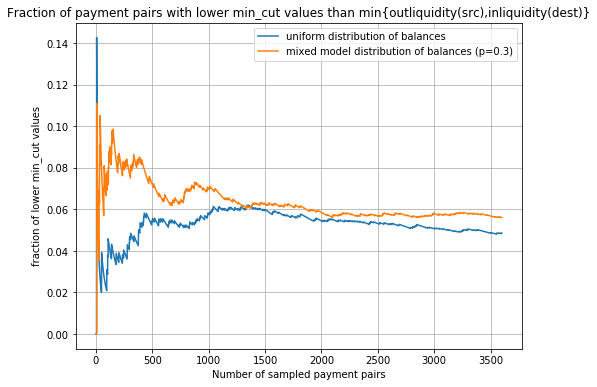

0.05611111111111111 0.04861111111111111


In [53]:
plt.figure(figsize=(8,6))
plt.title("Fraction of payment pairs with lower min_cut values than min{outliquidity(src),inliquidity(dest)}")
plt.plot(frequencys,label="uniform distribution of balances")
plt.plot(f_mixed_model,label="mixed model distribution of balances (p=0.3)")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("fraction of lower min_cut values")
plt.legend()
plt.show()

print(f_mixed_model[-1], frequencys[-1])

## Experiment 2: optimal splitting ratio

We want to emperically estimate the expected number of attempts needed for various splitting ratios. This is to test the hypothesis that an equidistant splitting for multipart payments works best

In [28]:
## TODO next

## Experiment 3: various splitting strategies

we want to test at least three splitting strategies

### Proposed greedy strategy: 
* compute the theoretic optimal split
* send out onions
* merge failed onions
* update knowledge of the graph
* repeat with the remaining amount

## c-lightning split
* do 10 attempts
* split in half
* repeat each half 

## Binary splitter
* not clear how to implement